In [1]:
!pip install datasets scikit-multilearn
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

target_labels = ["happiness", "surprise", "disgust", "anger", "neutral"]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 13.0 MB/s 
     |████████████████████████████████| 89 kB 6.4 MB/s 
     |████████████████████████████████| 132 kB 71.9 MB/s 
     |████████████████████████████████| 212 kB 68.9 MB/s 
     |████████████████████████████████| 182 kB 42.7 MB/s 
     |████████████████████████████████| 127 kB 54.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


#Reformat and Save Datasets

##Process and save emotion data as csv for manual labelling

In [ ]:
from datasets import load_dataset
target_labels = ["happiness", "surprise", "disgust", "anger", "neutral"]

def map_data_to_column(example):
  if example['label'] is 1:
    example['happiness'] = 1
  if example['label'] is 3:
    example['anger'] = 1
  if example['label'] is 5:
    example['surprise'] = 1
  
  return example

datasets_emotion = load_dataset("emotion")
emotion_dataset = datasets_emotion.get("train")
dummy_values = [0] * len(emotion_dataset)
for label in target_labels:
  emotion_dataset = emotion_dataset.add_column(label, dummy_values)
emotion_dataset = emotion_dataset.map(map_data_to_column)
emotion_dataset = emotion_dataset.remove_columns(['label'])

qualifying_data_index = []
for emotion_index, emotion_data in enumerate(emotion_dataset):
  sum_of_target_labels = 0
  for label in target_labels:
    sum_of_target_labels += emotion_data[label]
  if sum_of_target_labels >= 1:
    qualifying_data_index.append(emotion_index)
    
emotion_dataset = emotion_dataset.select(qualifying_data_index)
emotion_dataset = emotion_dataset.select(range(500))

emotion_dataset_csv_path = 'emotion.csv'
emotion_dataset.to_csv(emotion_dataset_csv_path, index=False)  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?ex/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

55826

##Process and save go emotions dataset

In [ ]:
from datasets import load_dataset, concatenate_datasets
def reformat_go_emotions():
  datasets_go_emotions = load_dataset("go_emotions", "raw")
  dataset_list = []
  
  for go_dataset in datasets_go_emotions:
    go_dataset = datasets_go_emotions.get(go_dataset)
    go_dataset = go_dataset.rename_column("joy", "happiness")
    qualifying_data_index = []
    for go_index, go_data in enumerate(go_dataset):
      sum_of_target_labels = 0
      for label in target_labels:
        sum_of_target_labels += go_data[label]
      if sum_of_target_labels >= 1:
        qualifying_data_index.append(go_index)
    go_dataset = go_dataset.select(qualifying_data_index)
    dataset_list.append(go_dataset)
  filtered_dataset = concatenate_datasets(dataset_list)
  
  features_to_keep = target_labels + ['text']
  for feature in filtered_dataset.features:
    if feature not in features_to_keep:
      filtered_dataset = filtered_dataset.remove_columns([feature])
  return filtered_dataset

In [ ]:
go_emotions_dataset = reformat_go_emotions()
go_emotions_dataset_csv_path = "go_emotions.csv"
go_emotions_dataset.to_csv(go_emotions_dataset_csv_path, index=False)  

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/raw/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/82 [00:00<?, ?ba/s]

6542457

#Preprocess Dataset

##Import datasets from fs 

In [2]:
from datasets import load_dataset

go_emotions_dataset_csv_path = "go_emotions.csv"
labelled_emotion_dataset_csv_path = "labelled_emotion.csv"

go_emotions_dataset = load_dataset("csv", data_files=go_emotions_dataset_csv_path)['train'].select(range(2000))
emotion_dataset = load_dataset("csv", data_files=labelled_emotion_dataset_csv_path)['train']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2ec0ba9a6acc3356/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-41e69d3674e155fa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
from datasets import concatenate_datasets
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

def organize_labels_into_single_feature(example):
  example['label'] = []
  for label in target_labels:
    example['label'].append(example[label])
  return example

dataset = concatenate_datasets([go_emotions_dataset, emotion_dataset])
dataset = dataset.map(organize_labels_into_single_feature)
dataset = dataset.remove_columns(target_labels)
dataset = dataset.shuffle(seed=42)

dataset_text = []
for text in dataset['text']:
  dataset_text.append([text])

x_train, y_train, x_val, y_val = iterative_train_test_split(np.array(dataset_text), np.array(dataset['label']), test_size=0.2)


  0%|          | 0/2500 [00:00<?, ?ex/s]

In [4]:
print(target_labels)
print(len(dataset['label']))
np.sum(np.array(dataset['label']), axis=0)

['happiness', 'surprise', 'disgust', 'anger', 'neutral']
2500


array([ 508,  173,  152,  347, 1392])

#Baseline Model

In [19]:
import torch
import numpy
from sklearn.metrics import f1_score
import os
import torchtext
from torchtext import data
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
class BaselineModel(torch.nn.Module):
    def __init__(self, vocab, embedding_size):
        super().__init__()
        self.embeddings = torch.nn.Embedding.from_pretrained(vocab.vectors)
        self.prediction_function = torch.nn.Linear(embedding_size, 5)
        
    def forward(self, x):
        averages = []
        sentence_word_vectors_with_padding = self.embeddings(x)
        
        # Remove paddings and compute list of average work embedding of each sentence
        for sentence in range(x.size(dim=1)):
            sentence_word_vectors = []
            for word in range(x.size(dim=0)):
                if word < x.size(dim=0) - 1 and x[word + 1, sentence].item() is 0 and x[word, sentence].item() is 0:
                    break
                elif word == x.size(dim=0) - 1 and x[word, sentence].item() is 0:
                    break
                current_word = sentence_word_vectors_with_padding[word, sentence]
                sentence_word_vectors.append(current_word)
            sentence_word_vectors = torch.stack(sentence_word_vectors)
            mean = torch.mean(sentence_word_vectors, dim=0)
            averages.append(mean)
        
        averages = torch.stack(averages)
        
        output = self.prediction_function(averages)
        
        return output

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-12-7c5011e8cdae>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if word < x.size(dim=0) - 1 and x[word + 1, sentence].item() is 0 and x[word, sentence].item() is 0:
<ipython-input-12-7c5011e8cdae>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if word < x.size(dim=0) - 1 and x[word + 1, sentence].item() is 0 and x[word, sentence].item() is 0:
<ipython-input-12-7c5011e8cdae>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif word == x.size(dim=0) - 1 and x[word, sentence].item() is 0:


In [13]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, text, label):

        X, Y = [], []
        V = len(vocab.vectors)
        for i, sentence in enumerate(text):
            L = sentence[0].split()
            X.append(torch.tensor([vocab.stoi.get(w.lower(), V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(label[i])
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 

def my_collate_function(batch, device):
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    batch_x = torch.stack(batch_x).t().int().to(device)
    batch_y = torch.stack(batch_y).to(device)
    
    return batch_x, batch_y


In [63]:
def main(args):
    # fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
    train_dataset = TextDataset(glove, args["train_text"], args["train_label"])
    val_dataset = TextDataset(glove, args["val_text"], args["val_label"])
        
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=args["batch_size"],
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=args["batch_size"], 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    # instantiate the network & set up the optimizer
    model = BaselineModel(glove, embedding_size=100).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
    loss_function = torch.nn.BCEWithLogitsLoss()
    training_losses = []
    training_accuracy = []
    validation_losses = []
    validation_accuracy = []
    validation_f1 = []

    # training loop
    for epoch in range(args["num_of_epochs"]):
        print(f"Epoch: {epoch}")
        total_loss = 0
        total_match = 0
        
        # Training
        for x, y in train_dataloader:
            optimizer.zero_grad()
            output = model(x).squeeze(1)
            
            # Compute loss
            loss = loss_function(output.float(), y.float())
            loss.backward()
            optimizer.step()
            
            # Evaluate
            prediction = torch.sigmoid(output) > 0.5
            match = prediction == y
            
            # Collect metrics 
            total_loss += loss.item()
            total_match += match.sum().item()
        
        training_losses.append(total_loss/(len(train_dataloader)*args["batch_size"]))
        training_accuracy.append(total_match/(len(train_dataloader)*args["batch_size"]*args["num_of_labels"]))
        
        if args.get("run_validation", True) is True:
            # Validating
            total_loss = 0
            total_match = 0
            predictions = []
            references = []
            for x, y in validation_dataloader:
                output = model(x).squeeze(1)

                # Compute loss
                loss = loss_function(output.float(), y.float())

                # Evaluate
                prediction = torch.sigmoid(output) > 0.5
                predictions.append(prediction)
                references.append(y)

                match = prediction == y

                # Collect metrics 
                total_loss += loss.item()
                total_match += match.sum().item()

            predictions = torch.stack(predictions).reshape(-1,5).cpu().int().numpy()
            references = torch.stack(references).reshape(-1,5).cpu().int().numpy()
            print(predictions.shape)
            print(references.shape)
            validation_losses.append(total_loss/(len(validation_dataloader)*args["batch_size"]))
            validation_accuracy.append(total_match/(len(validation_dataloader)*args["batch_size"]*args["num_of_labels"]))
            validation_f1.append(f1_score(references, predictions, average=None))
            print(validation_f1[0].shape)
        
    fig_loss, plot_loss = plt.subplots()
    fig_accuracy, plot_accuracy = plt.subplots()
    fig_f1, plot_f1 = plt.subplots()
    
    plot_loss.plot(training_losses, label = "Training Loss")
    plot_accuracy.plot(training_accuracy, label = [])
    
    if args.get("run_validation", True) is True:
        plot_loss.plot(validation_losses, label = "Validation Loss")
        plot_accuracy.plot(validation_accuracy, label = "Validation Accuracy")
        plot_f1.plot(validation_f1, label = "Validation F1")
    
    plot_loss.legend()
    plot_loss.set_xlabel('Epoch', fontsize=15)
    plot_loss.set_ylabel('Loss', fontsize=15)
    plot_loss.set_title('Training Curve')
    plot_loss.grid(True)
    
    plot_accuracy.legend()
    plot_accuracy.set_xlabel('Epoch', fontsize=15)
    plot_accuracy.set_ylabel('Accuracy', fontsize=15)
    plot_accuracy.set_title('Accuracy Curve')
    plot_accuracy.grid(True)

    plot_f1.legend(target_labels)
    plot_f1.set_xlabel('Epoch', fontsize=15)
    plot_f1.set_ylabel('F1', fontsize=15)
    plot_f1.set_title('F1 Curve')
    plot_f1.grid(True)
    
    fig_loss.savefig("baseline_loss.png")
    fig_accuracy.savefig("baseline_accuracy.png")
    fig_f1.savefig("baseline_f1.png")
    plt.show()
    
    torch.save(model.state_dict(), "model_baseline.pt")
    
    return model


Using device: cuda
Epoch: 0
(500, 5)
(500, 5)
(5,)
Epoch: 1
(500, 5)
(500, 5)
(5,)
Epoch: 2
(500, 5)
(500, 5)
(5,)
Epoch: 3
(500, 5)
(500, 5)
(5,)
Epoch: 4
(500, 5)
(500, 5)
(5,)
Epoch: 5
(500, 5)
(500, 5)
(5,)
Epoch: 6
(500, 5)
(500, 5)
(5,)
Epoch: 7
(500, 5)
(500, 5)
(5,)
Epoch: 8
(500, 5)
(500, 5)
(5,)
Epoch: 9
(500, 5)
(500, 5)
(5,)
Epoch: 10
(500, 5)
(500, 5)
(5,)
Epoch: 11
(500, 5)
(500, 5)
(5,)
Epoch: 12
(500, 5)
(500, 5)
(5,)
Epoch: 13
(500, 5)
(500, 5)
(5,)
Epoch: 14
(500, 5)
(500, 5)
(5,)
Epoch: 15
(500, 5)
(500, 5)
(5,)
Epoch: 16
(500, 5)
(500, 5)
(5,)
Epoch: 17
(500, 5)
(500, 5)
(5,)
Epoch: 18
(500, 5)
(500, 5)
(5,)
Epoch: 19
(500, 5)
(500, 5)
(5,)
Epoch: 20
(500, 5)
(500, 5)
(5,)
Epoch: 21
(500, 5)
(500, 5)
(5,)
Epoch: 22
(500, 5)
(500, 5)
(5,)
Epoch: 23
(500, 5)
(500, 5)
(5,)
Epoch: 24
(500, 5)
(500, 5)
(5,)
Epoch: 25
(500, 5)
(500, 5)
(5,)
Epoch: 26
(500, 5)
(500, 5)
(5,)
Epoch: 27
(500, 5)
(500, 5)
(5,)
Epoch: 28
(500, 5)
(500, 5)
(5,)
Epoch: 29
(500, 5)
(500, 5)
(5,)
E

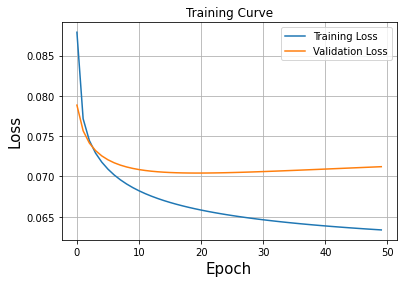

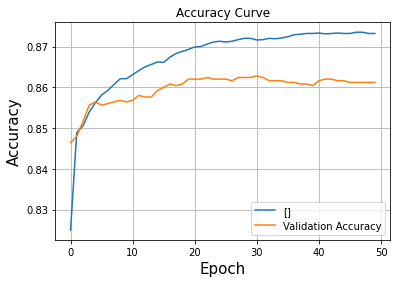

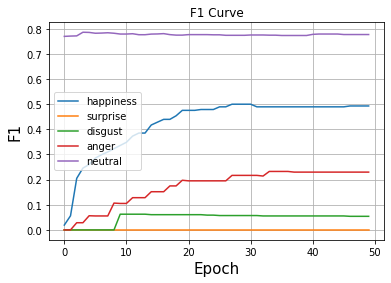

In [65]:
args = {
    "batch_size" : 5,
    "learning_rate": 0.002,
    "num_of_epochs": 50,
    "train_text": x_train,
    "train_label":  y_train, 
    "val_text": x_val, 
    "val_label":  y_val, 
    "num_of_labels": 5,
    "run_validation": True,
    }
model = main(args = args)

In [ ]:
def evaluate(text, vocab):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("Using device:", device)

  V = len(vocab.vectors)
  L = text.split()
  x = torch.tensor([[vocab.stoi.get(w.lower(), V-1) for w in L]]).t().int().to(device)
  output = model(x).squeeze(1)
  # Evaluate
  prediction = torch.sigmoid(output)
  print(f"Input:   \t{text}\n")
  for index, label in enumerate(target_labels):
    print(f"{label}:   \t{prediction[0, index].item():.4f}\n")

glove = torchtext.vocab.GloVe(name="6B",dim=100)
evaluate("I cannot tell how I hate this", glove)

Using device: cuda
Input:   	I cannot tell how I hate this

happiness:   	0.0529

surprise:   	0.0745

disgust:   	0.2830

anger:   	0.5113

neutral:   	0.2204

